# Power Analysis for Proportion Metric at Group Size of 500

*A brief exploration of how often one is able to identify significant differences for various effect sizes.  We'll base this around a hypothetical research design where we are looking at how using social media impacts communication with friends and family.*
<br><br>
**Manipulation:** Using Social Media or Not Using Social Media
<br>
**Measurement:** % Answering "Yes" to "Have you communicated with a friend or family member in the past 24 hours?"

In [1]:
# import necessary libraries
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import random
%matplotlib inline

# cleaning notebook
import warnings
warnings.filterwarnings("ignore")

In [2]:
# returns 1 if "Yes" and 0 if "No"
def simulate_response(likelihood_of_yes):
    
    random_number = random.random()
    
    if random_number < likelihood_of_yes:
        return 1
    else:
        return 0

# can simulate set of responses
def simulate_responses(
    initial_likelihood_of_yes,
    number_of_exposures=1,
    likelihood_of_repeat=0
):
    
    # initialize response list
    responses = []
    
    # simulate first response
    r = simulate_response(initial_likelihood_of_yes)
    responses.append(r)
    
    
    # simulate additional responses
    for additional_exposure in range(number_of_exposures-1):
        
        random_number = random.random()

        if random_number <= likelihood_of_repeat:
            responses.append(r)
        else:
            r = simulate_response(initial_likelihood_of_yes)
            responses.append(r)
        
    return responses


# create a list of responses based on a given likelihood    
def sample_n_responses(
    sample_size,
    initial_likelihood_of_yes,
    number_of_exposures_per_respondent=1,
    likelihood_of_repeat=0
):
    
    #initialize responses
    responses = []
    
    #append response(s) for every respondent
    for respondent in range(sample_size):
        responses.extend(
            simulate_responses(
                initial_likelihood_of_yes,
                number_of_exposures=number_of_exposures_per_respondent,
                likelihood_of_repeat=likelihood_of_repeat
            )
        )
        
    return responses


# get p value comparing two groups with different true likelihoods
def simulate_two_group_test(
    group_size, 
    g1_likelihood, 
    g2_likelihood,
    number_of_exposures_per_respondent=1,
    likelihood_of_repeat=0
):
    
    group_1 = sample_n_responses(
        group_size, 
        g1_likelihood,
        number_of_exposures_per_respondent=number_of_exposures_per_respondent,
        likelihood_of_repeat=likelihood_of_repeat
    )
    
    group_2 = sample_n_responses(
        group_size, 
        g2_likelihood,
        number_of_exposures_per_respondent=number_of_exposures_per_respondent,
        likelihood_of_repeat=likelihood_of_repeat
    )
    
    stats = {
        'group_1_mean': np.mean(group_1),
        'group_2_mean': np.mean(group_2),
        'p_value': sp.stats.ttest_ind(group_1,group_2)[1]
    }
    return stats


# see how often a ttest identifies the correct effect
def estimate_statistical_power(
    g1_likelihood, g2_likelihood, group_size, 
    x_per_respondent=1,
    likelihood_of_repeat=0,
    simulations=10000, p=.05
):
    
    correct_effect_identified_tracker = []
    
    if g1_likelihood == g2_likelihood:
        return "error - input differing likelihoods"
    
    if g1_likelihood > g2_likelihood:
        gmean = 'group_1_mean'
        lmean = 'group_2_mean'
        
    if g2_likelihood > g1_likelihood:
        gmean = 'group_2_mean'
        lmean = 'group_1_mean'
        
    for i in range(simulations):
        
        stats = simulate_two_group_test(
            group_size, g1_likelihood, g2_likelihood,
            number_of_exposures_per_respondent=x_per_respondent,
            likelihood_of_repeat=likelihood_of_repeat
        )
        
        if (stats[gmean] > stats[lmean]) & (stats['p_value'] < p):
            correct_effect_identified_tracker.append([1])
            
        else:
            correct_effect_identified_tracker.append([0])
            
    return np.mean(correct_effect_identified_tracker)

    
# run simulations for combinations of specified ranges, return to dataframe
def get_powers_for_ranges(
    initial_likelihood_range,
    percentage_point_difference_range,
    n_per_group,
    x_per_respondent=1,
    likelihood_of_repeat=0,
    simulations=10000, p=.05
):
    
    results = pd.DataFrame()
    for likelihood in initial_likelihood_range:
        for ppdiff in percent_point_difference_range:
            n = n_per_group
            l1 = likelihood
            l2 = likelihood + ppdiff
            
            power = estimate_statistical_power(
                l1, l2,
                n_per_group,
                x_per_respondent=x_per_respondent,
                likelihood_of_repeat=likelihood_of_repeat,
                simulations=simulations, p=p
            )
            
            row = {
                'starting_likelihood':l1, 
                'percentage_point_difference': ppdiff, 
                'power': power
            }
            
            results = results.append(row, ignore_index= True)
    return results

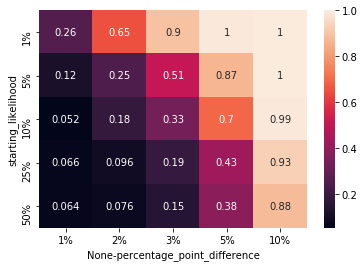

In [3]:

# let's look at a range of initial likelihoods from 1% to 50%
initial_likelihood_range = [.01,.05,.1,.25,.5]

# let's look at percentage point differences from 1% to 10%
percent_point_difference_range = [.01, .02, .03, .05, .10]


# we can keep sample size constant at 500
sample_size = 500

results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                simulations=500, p=.05)


# look at color-coded grid of results
reformatted = results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

Capturing only a single exposure, we reliably have a 90%+ chance of detecting effect sizes of 10 percentage points, with our power to detect effect sizes of 5 percentage points ranging from ~36% to 100% depending on the starting likelihood.

Let's run that again except look at how likely we are to hit a p-value of 10%.

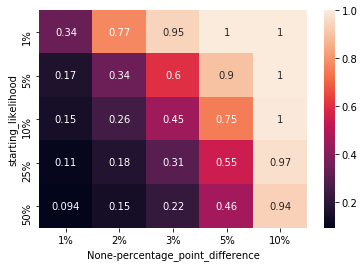

In [4]:
# look at color-coded grid of results
p10_results = get_powers_for_ranges(initial_likelihood_range,
                                    percent_point_difference_range,
                                    sample_size,
                                    simulations=500, p=.1)

p10_reformatted = p10_results.pivot(index='starting_likelihood', 
                                    columns='percentage_point_difference')

ax = sns.heatmap(p10_reformatted, annot=True, 
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

By adjusting to a p=10% standard, we get some help with 5 percentage point effect sizes, giving us -- at worst -- ~50/50 odds.
<br>
Similarly, power is boosted for 10 percentage point effects so we capture them nearly 95% of the time.
<br><br>
Since these numbers are lower than ideal, let's plan on pulling six distinct measures from each respondent.  How does this change our analysis?

Text(0.5,1,'0% Chance of Longitudinal Repeats')

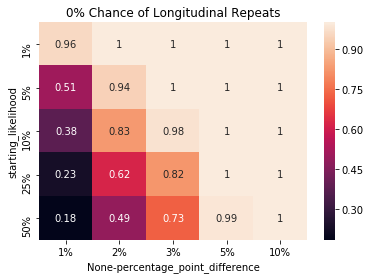

In [5]:
# first let's try this assuming that each longitudinal measure has no bearing on the others -- an unlikely but ideal scenario
cluster_results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                x_per_respondent=6,
                                likelihood_of_repeat=0,
                                simulations=500, p=.1)


# look at color-coded grid of results
cluster_reformatted = cluster_results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(cluster_reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('0% Chance of Longitudinal Repeats')

Text(0.5,1,'50% Chance of Longitudinal Repeats')

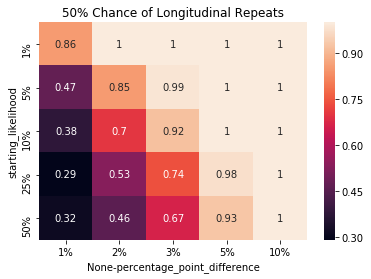

In [6]:
# now let's see what happens if the odds of a repeat are 50%
cluster_results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                x_per_respondent=6,
                                likelihood_of_repeat=0.5,
                                simulations=500, p=.1)


# look at color-coded grid of results
cluster_reformatted = cluster_results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(cluster_reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('50% Chance of Longitudinal Repeats')

Text(0.5,1,'99% Chance of Longitudinal Repeats')

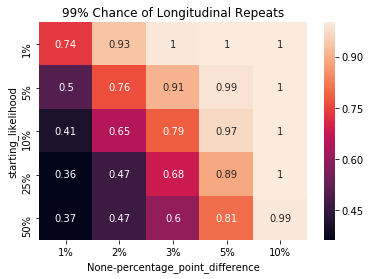

In [7]:
# lastly, let's see what happens if the odds of a repeat are 99%
cluster_results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                x_per_respondent=6,
                                likelihood_of_repeat=0.99,
                                simulations=500, p=.1)


# look at color-coded grid of results
cluster_reformatted = cluster_results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(cluster_reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('99% Chance of Longitudinal Repeats')

From this simulation, it looks like depending on how independently sequenced metrics operate, we could see our power to detect 5% differences off of a 50% score increase to anywhere from ~80% to 98%.
<br><br>
Let's quickly look at some scenarios for subsets of 100 respondents.

Text(0.5,1,'n=100 Comparisons, Single Metric')

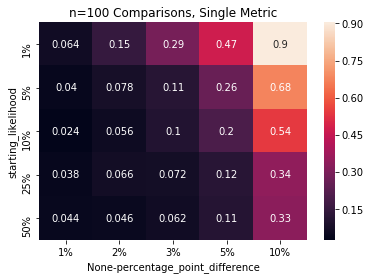

In [8]:
sample_size = 100

results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                simulations=500, p=.05)


# look at color-coded grid of results
reformatted = results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('n=100 Comparisons, Single Metric')

Text(0.5,1,'n=100 Comparisons, Sequence of Six Metrics')

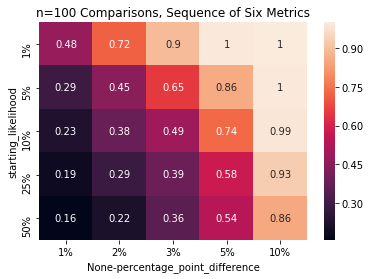

In [9]:
sample_size = 100

results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                x_per_respondent=6,
                                likelihood_of_repeat=0.5,
                                simulations=500, p=.1)


# look at color-coded grid of results
reformatted = results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('n=100 Comparisons, Sequence of Six Metrics')

While the power is low for the n=100 comparisons, using a sequence of metrics lets us capture over 85% of effects that are 10 percentage points or more.  Lets see how getting twice as many metrics impacts -- or two measurements per week -- impacts this.

Text(0.5,1,'n=100 Comparisons, Sequence of Twelve Metrics')

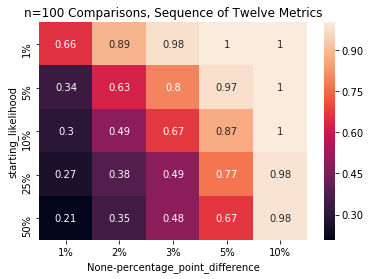

In [10]:
sample_size = 100

results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                x_per_respondent=12,
                                likelihood_of_repeat=0.5,
                                simulations=500, p=.1)


# look at color-coded grid of results
reformatted = results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('n=100 Comparisons, Sequence of Twelve Metrics')

By collecting two measurements a week, we could nearly guarantee that effects of 10 percentage points or more will be observed as statistically significant differences, even if we assume a level of interaction within a longitudinal design.